In [54]:
import sys
sys.path.append('../../')
from search import search_local
import numpy as np
from tools.tools import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Define parammeters for dividing up Rz space into rectangular bins. All units in kpc.

In [55]:
R_max = 10.
R_min = 5.
z_max = 1.
z_min = -1.
R_pixel = 0.001
z_pixel = 0.001
bin_R = (R_max - R_min)/R_pixel
bin_z = (z_max - z_min)/z_pixel
epsilon = 0.05 # the radius around sun that we assume has most stars

In [56]:
print(bin_R)
print(bin_z)

5000.0
2000.0


Get gaia catalogue, convert from cartesian to cylindrical

In [57]:
samples = search_local.get_entire_catalogue()
x, y, z, vx, vy, vz = samples.T
cylcoord = rect_to_cyl(x, y, z, vx, vy, vz)
R = cylcoord[:, 0]
z = cylcoord[:, 3]

Get stars close to the sun: epsilon kpc around sun

In [58]:
sun_galactic = np.array([0, 0, 0, 0, 0, 0])
close_stars = search_local.search_phase_space(*sun_galactic, epsilon = epsilon, v_scale = 0)
x_close, y_close, z_close, vx_close, vy_close, vz_close = close_stars.T
cyl_close = rect_to_cyl(x_close, y_close, z_close, vx_close, vy_close, vz_close)
R_close = cyl_close[:, 0]
z_close = cyl_close[:, 3]

Plot 2d histogram of gaia catalogue

Text(0.5,1,'Density Plot of All Gaia Data')

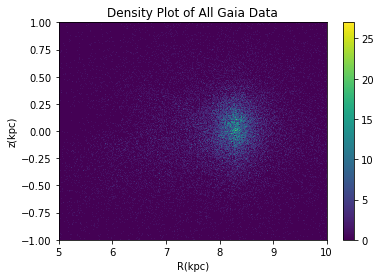

In [59]:
histogram, xedges, yedges, graph = plt.hist2d(R, z, bins = (bin_R, bin_z), range = [[R_min, R_max],[z_min, z_max]])
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Density Plot of All Gaia Data")

Define a function that get the gaia number density function from histogram result

In [60]:
def n_gaia(Rz):
    R = Rz[0]
    z = Rz[1]
    R_index = ((R-R_min)/R_pixel).astype(int)
    z_index = ((z-z_min)/z_pixel).astype(int)
    result = []
    for i in range(np.size(R_index)):
        result.append(histogram[R_index[i]][z_index[i]])
    return np.array(result)

Define the true number density function; scale length in unit of kpc

In [61]:
def n(Rz, n_0):
    R = Rz[0]
    z = Rz[1]
    return n_0*np.exp(-R/3 - np.abs(z)/0.3)

Curve fit the true number density function against gaia data in epsilon radius. Solve for the value of initial number density, and find the standard deviation of this value.

In [62]:
Rz = np.array([R_close, z_close])
np.shape(Rz)
popt, pcov = curve_fit(n, Rz, n_gaia(Rz))
n_0 = popt[0]
std_n_0 = pcov[0][0]
print("optimized n_0 =", n_0)
print("standard deviation of n_0 =", std_n_0)

3317
1063
3294
1063
3298
1036
3296
1055
3296
1055
3294
1067
3298
1037
3297
1058
3295
1068
3296
1066
3298
1048
3298
1060
3297
1051
3296
1061
3296
1059
3298
1048
3297
1059
3298
1055
3300
1064
3300
1053
3300
1060
3300
1060
3300
1041
3300
1039
3300
1038
3300
1066
3300
1046
3301
1067
3301
1063
3302
1065
3301
1054
3302
1065
3302
1061
3303
1059
3303
1058
3302
1062
3303
1062
3302
1051
3305
1067
3306
1062
3306
1062
3300
1060
3301
1059
3301
1056
3302
1064
3302
1047
3301
1050
3302
1057
3302
1050
3301
1049
3303
1064
3301
1040
3305
1057
3305
1059
3305
1058
3303
1049
3306
1060
3306
1061
3306
1055
3299
1059
3300
1056
3300
1047
3300
1047
3300
1044
3300
1050
3300
1055
3301
1049
3302
1059
3301
1052
3301
1051
3301
1051
3301
1052
3301
1047
3301
1043
3305
1053
3301
1035
3304
1053
3301
1034
3305
1048
3307
1050
3306
1050
3306
1050
3306
1045
3309
1051
3303
1061
3304
1060
3303
1049
3302
1048
3304
1053
3301
1033
3306
1053
3307
1061
3306
1055
3304
1044
3304
1043
3307
1054
3307
1057
3305
1045
3310
1058
3303
1041


3299
998
3298
998
3296
977
3299
984
3300
1008
3300
978
3300
1011
3302
977
3301
980
3302
994
3302
994
3305
996
3304
980
3303
989
3307
980
3298
988
3298
985
3297
1004
3296
988
3296
988
3298
993
3298
979
3300
993
3298
992
3299
1004
3302
990
3307
982
3306
987
3305
983
3305
980
3301
1002
3302
979
3303
995
3303
989
3303
989
3305
980
3304
986
3303
985
3287
991
3286
992
3285
985
3295
1013
3289
989
3290
988
3287
987
3285
987
3288
998
3288
998
3286
988
3287
993
3293
1009
3293
1009
3285
991
3292
1006
3293
1005
3286
982
3287
991
3292
990
3296
1003
3294
980
3292
987
3295
1002
3288
983
3293
996
3292
992
3289
986
3294
1005
3297
1013
3297
1014
3292
984
3297
1019
3284
987
3286
991
3285
982
3282
988
3283
990
3284
990
3288
997
3286
991
3284
987
3289
1002
3285
991
3286
990
3286
990
3288
987
3291
983
3292
988
3291
994
3288
985
3291
1002
3290
995
3290
990
3295
1006
3295
1006
3290
982
3294
980
3296
992
3297
996
3296
992
3296
991
3294
979
3298
986
3298
980
3299
1009
3299
995
3298
1000
3297
1001
3295
985
3297


1022
3329
1023
3329
1023
3315
1025
3332
1018
3322
1020
3330
1020
3328
1021
3329
1022
3334
1023
3332
1020
3312
1025
3329
1022
3321
1006
3321
1006
3313
1014
3329
1000
3313
1015
3329
1004
3312
1016
3329
1003
3318
1011
3328
1002
3312
1016
3316
1014
3327
1007
3305
1023
3327
1009
3330
1004
3326
1007
3321
1011
3331
1005
3315
1018
3315
1018
3317
1016
3319
1016
3313
1016
3331
1005
3331
1005
3331
1005
3331
1005
3326
1010
3333
1005
3334
1005
3321
1015
3322
1004
3328
999
3323
1002
3325
1003
3327
1005
3319
1007
3326
1001
3307
1020
3329
1004
3308
1019
3328
1003
3334
999
3316
1015
3329
1004
3316
1016
3324
1010
3332
1005
3327
1012
3332
1006
3325
1011
3330
1007
3323
1008
3335
1005
3336
1006
3327
1009
3328
1013
3332
1011
3332
1013
3329
1014
3332
1013
3335
1013
3334
1014
3327
1016
3320
1020
3328
1015
3329
1016
3330
1012
3310
1022
3323
1016
3333
1013
3336
1013
3335
1013
3320
1022
3331
1021
3331
1021
3321
1023
3328
1018
3323
1023
3331
1021
3333
1020
3336
1008
3322
1015
3332
1011
3320
1016
3336
1010
3321
10

3283
1054
3291
1041
3297
1031
3297
1031
3291
1042
3289
1048
3289
1048
3288
1048
3288
1050
3295
1036
3292
1042
3292
1043
3290
1049
3290
1049
3290
1048
3294
1041
3296
1038
3293
1043
3290
1045
3289
1046
3297
1032
3287
1053
3292
1043
3287
1055
3293
1041
3286
1052
3290
1044
3288
1049
3292
1040
3290
1044
3289
1048
3292
1042
3289
1050
3291
1046
3290
1051
3293
1043
3290
1052
3295
1040
3286
1046
3290
1041
3286
1046
3292
1038
3292
1038
3282
1052
3290
1042
3280
1057
3280
1052
3276
1057
3275
1058
3287
1044
3279
1055
3276
1058
3277
1057
3276
1057
3278
1055
3282
1052
3282
1052
3277
1059
3295
1032
3286
1048
3281
1059
3280
1057
3283
1053
3285
1050
3288
1051
3285
1059
3287
1054
3285
1059
3291
1046
3287
1051
3289
1047
3292
1043
3287
1055
3291
1048
3290
1055
3294
1042
3297
1033
3291
1046
3291
1046
3286
1060
3288
1058
3289
1054
3282
1061
3286
1052
3287
1051
3280
1062
3281
1062
3287
1050
3290
1046
3290
1045
3284
1056
3281
1064
3294
1039
3292
1046
3286
1061
3293
1045
3293
1045
3285
1064
3289
1051
3297
1035


1011
3319
1012
3325
1010
3315
1017
3313
1018
3321
1010
3316
1015
3316
1015
3323
1011
3325
1010
3318
1015
3322
1013
3315
1018
3314
1012
3309
1016
3318
1007
3314
1012
3319
1009
3317
1011
3313
1017
3317
1013
3315
1014
3313
1017
3320
1012
3314
1013
3305
1021
3317
1011
3320
1009
3315
1013
3301
1025
3304
1023
3304
1023
3304
1023
3323
1011
3313
1017
3318
1014
3317
1016
3320
1015
3322
1015
3323
1014
3321
1013
3316
1017
3313
1020
3321
1017
3316
1020
3319
1019
3329
1010
3320
1015
3325
1013
3323
1014
3328
1011
3329
1014
3331
1015
3329
1015
3328
1013
3316
1018
3316
1018
3322
1018
3325
1017
3329
1017
3330
1017
3322
1020
3328
1019
3329
1019
3330
1021
3328
1018
3320
1021
3328
1019
3320
1022
3327
1019
3323
1021
3329
1021
3323
1023
3324
1022
3312
1025
3325
1023
3325
1024
3316
1025
3326
1015
3314
1021
3316
1020
3322
1018
3320
1019
3311
1022
3325
1018
3322
1019
3322
1020
3319
1021
3325
1020
3319
1021
3315
1021
3317
1020
3322
1020
3323
1020
3314
1022
3321
1021
3316
1023
3321
1021
3321
1023
3313
1025
3319


3326
1032
3344
1035
3339
1035
3333
1033
3323
1031
3346
1038
3330
1034
3339
1038
3326
1033
3321
1034
3337
1040
3342
1042
3312
1032
3340
1044
3344
1045
3339
1042
3331
1036
3323
1034
3323
1034
3344
1042
3340
1039
3341
1041
3334
1038
3315
1032
3339
1040
3342
1043
3345
1043
3343
1043
3317
1033
3340
1034
3328
1032
3344
1036
3345
1037
3324
1032
3336
1036
3347
1035
3332
1033
3332
1033
3340
1036
3340
1036
3342
1040
3326
1034
3318
1033
3341
1037
3334
1035
3343
1038
3335
1036
3330
1035
3341
1037
3326
1032
3343
1038
3343
1039
3337
1037
3329
1040
3331
1042
3337
1043
3315
1034
3343
1047
3315
1033
3330
1042
3334
1045
3325
1040
3317
1036
3336
1044
3337
1042
3334
1041
3332
1041
3326
1037
3318
1034
3325
1038
3322
1037
3332
1042
3329
1039
3335
1042
3324
1038
3337
1047
3323
1039
3338
1048
3328
1043
3328
1043
3328
1042
3339
1050
3321
1040
3324
1042
3334
1046
3341
1050
3335
1047
3323
1038
3327
1040
3337
1047
3322
1040
3340
1047
3338
1047
3343
1043
3333
1039
3338
1041
3341
1042
3334
1041
3337
1042
3337
1042


1070
3310
1070
3310
1070
3304
1048
3309
1069
3307
1062
3311
1069
3309
1060
3306
1047
3313
1066
3314
1070
3309
1057
3301
1065
3301
1070
3302
1073
3302
1073
3303
1071
3303
1069
3303
1063
3303
1067
3302
1059
3303
1062
3302
1043
3303
1046
3308
1072
3306
1066
3302
1050
3302
1050
3305
1067
3305
1065
3306
1063
3305
1056
3304
1047
3307
1067
3304
1045
3305
1047
3307
1059
3305
1048
3307
1055
3311
1065
3310
1066
3310
1062
3305
1049
3303
1040
3311
1070
3311
1070
3311
1071
3306
1050
3312
1071
3311
1066
3306
1047
3313
1070
3313
1069
3307
1049
3306
1046
3312
1065
3311
1059
3309
1052
3305
1040
3311
1057
3311
1056
3316
1070
3314
1065
3312
1058
3313
1060
3309
1049
3310
1064
3313
1066
3313
1065
3314
1067
3312
1063
3307
1048
3313
1064
3312
1059
3315
1068
3313
1060
3314
1061
3314
1060
3315
1061
3269
1062
3279
1055
3272
1065
3274
1065
3290
1041
3288
1042
3278
1059
3294
1035
3279
1063
3279
1063
3279
1063
3278
1066
3289
1047
3285
1056
3284
1056
3289
1048
3292
1043
3277
1068
3281
1060
3279
1071
3279
1068
3275


3274
1017
3273
1017
3268
1025
3276
1025
3260
1026
3265
1026
3269
1026
3270
1024
3265
1028
3265
1029
3262
1028
3272
1028
3287
1026
3276
1026
3270
1027
3259
1020
3263
1020
3262
1022
3260
1022
3273
1026
3273
1025
3263
1027
3279
1026
3272
1024
3278
1024
3278
1024
3260
1025
3275
1026
3282
1026
3283
1028
3283
1028
3266
1030
3267
1029
3267
1029
3257
1029
3260
1031
3256
1033
3272
1031
3265
1031
3280
1030
3274
1031
3260
1034
3265
1034
3271
1033
3277
1030
3258
1033
3258
1033
3260
1033
3274
1028
3284
1027
3270
1027
3277
1027
3268
1028
3278
1027
3269
1030
3266
1030
3273
1031
3262
1032
3285
1028
3261
1032
3268
1031
3266
1031
3282
1023
3265
1020
3269
1020
3268
1020
3263
1020
3269
1022
3262
1020
3283
1023
3279
1021
3272
1019
3274
1021
3289
1025
3269
1020
3280
1024
3262
1022
3266
1022
3295
1026
3264
1021
3276
1023
3276
1023
3280
1024
3281
1024
3280
1021
3269
1017
3278
1021
3268
1019
3269
1019
3279
1019
3281
1021
3267
1020
3275
1023
3282
1023
3280
1023
3287
1024
3275
1021
3274
1021
3282
1023
3272
1022


999
3312
994
3312
998
3311
990
3308
1002
3306
1006
3310
995
3304
1013
3313
991
3314
996
3306
991
3307
991
3306
992
3303
1006
3304
1008
3301
1022
3308
990
3312
987
3307
998
3305
1000
3310
985
3309
990
3304
1012
3308
996
3310
996
3312
993
3309
1000
3309
1000
3304
1014
3314
990
3310
1001
3316
989
3311
999
3308
1007
3312
999
3315
992
3313
999
3317
991
3312
992
3315
988
3312
992
3315
987
3316
991
3311
1004
3316
997
3309
1010
3311
1006
3310
1008
3312
1008
3307
1015
3311
1006
3311
1008
3313
1006
3312
1000
3317
996
3318
994
3308
1013
3316
1002
3321
998
3314
1007
3319
1001
3319
1002
3324
998
3319
1005
3325
998
3317
1008
3318
1003
3318
1002
3320
1001
3309
1016
3321
1001
3326
997
3327
998
3308
1017
3320
1003
3316
996
3312
1003
3314
1003
3322
992
3319
998
3322
995
3314
1005
3319
990
3316
997
3319
993
3322
990
3322
988
3320
996
3318
999
3320
997
3313
1005
3317
1002
3318
1002
3321
999
3317
1004
3314
1008
3327
994
3327
998
3286
1000
3296
1020
3281
989
3290
1004
3284
990
3283
992
3288
1004
3284
990
32

3297
1039
3296
1039
3296
1040
3294
1047
3296
1038
3294
1048
3295
1045
3295
1048
3299
1033
3299
1046
3299
1043
3299
1036
3299
1038
3300
1034
3301
1040
3300
1038
3302
1038
3301
1037
3301
1035
3300
1039
3301
1042
3300
1035
3301
1044
3302
1035
3304
1042
3303
1040
3304
1043
3302
1042
3304
1044
3303
1041
3300
1043
3300
1045
3300
1048
3301
1043
3299
1043
3299
1037
3302
1044
3303
1039
3303
1049
3303
1049
3302
1042
3297
1013
3298
1012
3299
1019
3299
1017
3299
1013
3300
1010
3299
1013
3299
1003
3300
1016
3300
1009
3300
1004
3300
1007
3301
1010
3301
1005
3301
1013
3301
1017
3302
1010
3302
1014
3300
1013
3300
1010
3300
1010
3300
1011
3300
1014
3300
1013
3301
1015
3301
1014
3301
1019
3303
1015
3302
1010
3304
1011
3303
1017
3303
1017
3304
1014
3302
1019
3302
1020
3302
1019
3303
1020
3303
1020
3305
1013
3302
1020
3300
1014
3303
1006
3302
1007
3304
1007
3305
1008
3304
1012
3304
1013
3302
1012
3305
1010
3305
1012
3306
1012
3304
1014
3307
1010
3304
1018
3306
1016
3308
1016
3307
1015
3309
1011
3309
1012


1040
3254
1042
3261
1040
3266
1037
3277
1035
3269
1033
3256
1037
3256
1037
3267
1034
3257
1037
3259
1037
3265
1037
3272
1035
3254
1041
3284
1031
3253
1042
3261
1040
3253
1043
3282
1032
3281
1025
3281
1026
3280
1026
3286
1026
3275
1027
3279
1028
3277
1029
3278
1028
3276
1029
3289
1028
3281
1030
3273
1032
3282
1030
3281
1028
3289
1028
3289
1028
3276
1030
3271
1031
3275
1030
3276
1030
3274
1031
3273
1031
3277
1031
3281
1030
3270
1032
3272
1033
3281
1031
3273
1032
3275
1031
3276
1032
3282
1030
3279
1032
3274
1034
3270
1036
3268
1038
3278
1030
3278
1031
3280
1032
3281
1032
3278
1033
3279
1033
3283
1033
3276
1035
3281
1034
3277
1036
3274
1037
3275
1038
3273
1034
3290
1029
3282
1032
3284
1032
3273
1036
3280
1034
3287
1031
3272
1038
3274
1037
3276
1036
3271
1039
3279
1034
3280
1034
3278
1036
3279
1036
3285
1034
3275
1032
3268
1034
3270
1034
3273
1034
3273
1034
3272
1035
3288
1030
3267
1039
3264
1039
3272
1037
3274
1035
3285
1032
3264
1040
3273
1034
3282
1032
3270
1037
3270
1037
3273
1034
3269


3284
997
3283
995
3283
999
3283
991
3279
989
3285
998
3290
1007
3280
988
3262
1011
3280
1018
3280
1018
3267
1012
3262
1009
3263
1011
3261
1009
3264
1009
3263
1008
3267
1012
3273
1016
3285
1021
3276
1017
3267
1014
3263
1012
3266
1014
3266
1014
3268
1015
3259
1010
3287
1022
3258
1006
3258
1009
3289
1022
3258
1005
3269
1010
3265
1008
3274
1011
3263
1004
3269
1007
3267
1008
3274
1012
3279
1016
3277
1015
3260
1006
3258
1005
3260
1007
3259
1007
3270
1012
3263
1006
3258
1004
3264
1006
3264
1006
3263
1014
3257
1010
3258
1011
3261
1013
3256
1010
3262
1012
3269
1014
3269
1013
3270
1014
3282
1020
3259
1014
3259
1013
3257
1014
3254
1012
3265
1013
3264
1013
3255
1010
3257
1008
3257
1007
3263
1008
3276
1015
3260
1005
3281
1018
3255
1009
3261
1012
3258
1007
3262
1008
3267
1012
3263
1010
3277
1016
3273
1010
3271
1007
3266
1004
3261
1001
3261
1000
3265
1005
3282
1015
3262
1002
3274
1009
3274
1009
3268
1004
3275
1008
3275
1008
3267
1003
3274
1009
3264
1002
3265
1003
3272
1007
3260
999
3284
1016
3266
100

Define a new, optimize theoretical density function that uses the optimize n_0, as well as being able to handle meshgrid

In [63]:
def n_optimized(R, z):
    return n_0*np.exp(-R/3 - np.abs(z)/0.3)

Graph the theoretical prediction of number density from the curve fit over entire space with Gaia data

Text(0.5,1,'Density Plot of Theoretical Prediction')

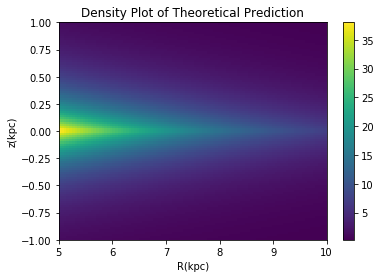

In [64]:
R_linspace = np.linspace(R_min, R_max, 100)
z_linspace = np.linspace(z_min, z_max, 100)
Rv, zv = np.meshgrid(R_linspace, z_linspace)
plt.pcolor(Rv, zv, n_optimized(Rv,zv))
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Density Plot of Theoretical Prediction")

Graph the theoretical prediction of number density from the curve fit over epsilon region of sun and compare with real number density

Text(0.5,0.98,'Comparison of Theoretical and Real Density in Epsilon Region')

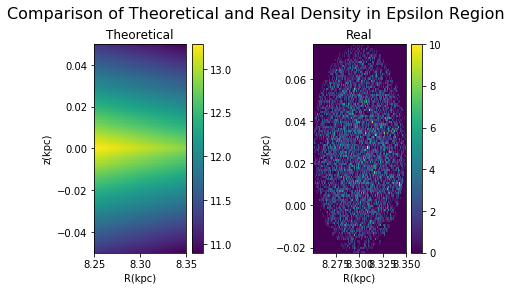

In [65]:
plt.figure(1)
plt.subplot(121)
R_linspace = np.linspace(8.3 - epsilon, 8.3+epsilon, 100)
z_linspace = np.linspace(- epsilon, epsilon, 100)
Rv, zv = np.meshgrid(R_linspace, z_linspace)
plt.pcolor(Rv, zv, n_optimized(Rv,zv))
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Theoretical")

plt.subplot(122)
plt.hist2d(R_close, z_close, bins = 100)
plt.colorbar()
plt.xlabel('R(kpc)')
plt.ylabel('z(kpc)')
plt.title("Real")
plt.subplots_adjust(wspace=0.9, top = 0.85)
plt.suptitle('Comparison of Theoretical and Real Density in Epsilon Region', fontsize=16)

Seeing how mismatched exponential density is, try spherical.

In [66]:
n_optimized(8.3,0.)

13.086859652242778

In [72]:
n_gaia(np.array([8.3, 0.]))

IndexError: invalid index to scalar variable.